# Using NZRA Data as Targets

We have refined the AI task to better reflect how the model will be used at inference time. The task is as follows:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

This is the first experiment which we are developing & running on the NIWA HPC.

## Experiment Setup
- do imports
- set up project wide settings & variables

In [1]:
%load_ext autoreload

In [ ]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [ ]:
# imports from external libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from deepsensor.train.train import set_gpu_default_device
import deepsensor.torch
from mpl_toolkits.basemap import Basemap

In [5]:
# variables for this experiment

dev = True # only use small datasets while in dev

years = [2017]
target_variable = TEMPERATURE

if not dev: # no GPU available on dev node
    set_gpu_default_device()

use_absolute_filepaths(True)


## Preprocess the datasets

In [7]:
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
h8_processor = ProcessHimawari8()
station_processor = ProcessStations(mode="csv")

In [ ]:
# load datasets
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)
h8_ds = h8_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)
stations_df = station_processor.load_df([TEMPERATURE], csv_file='esnz-observations_temp_20170101-20171231.csv', year_start=2017, year_end=2017)

In [ ]:
# make small subsets for the dev environment
if dev:
    # filter all datasets to the first 48 time steps (48 hours)
    nzra_ds = nzra_ds.isel(time=slice(0, 48))
    h8_ds   = h8_ds.isel(time=slice(0, 48))
    era5_ds = era5_ds.isel(time=slice(0, 48))
    stations_df = stations_df[(stations_df['time'] > nzra_ds['time'].values.min()) & (stations_df['time'] < nzra_ds['time'].values.max())]

    # set topography coarsening factor
    TOPO_COARSEN = 5
else:
    TOPO_COARSEN = 1

In [ ]:
# preprocess the stations
stations_df = stations_df[[TEMPERATURE, LATITUDE, LONGITUDE, TIME]]

stations_reset = stations_df.reset_index()
stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[[TEMPERATURE]]
stations_resample = stations_resample.reset_index().set_index([TIME, LATITUDE, LONGITUDE]).sort_index()

/var/tmp/pbs.1566948.pbsserver01/ipykernel_125914/557100680.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[[TEMPERATURE]]


In [ ]:
# preprocess NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

In [ ]:
# preprocess ERA5
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# add sun angle and culmination to ERA5 dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

In [ ]:
# preprocess auxiliary dataset (topography, tpi, land/sea mask)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])
ds_aux = ds_aux.reindex({LATITUDE: nzra_ds[LATITUDE], LONGITUDE: nzra_ds[LONGITUDE]}, method='nearest') # expand to the NZRA grid

ds_aux[LAND_SEA_MASK] = ds_aux[ELEVATION].where(ds_aux[ELEVATION].isnull(), 1, 0).fillna(0)

ds_aux_coarse  = ds_aux.coarsen(
    lat=TOPO_COARSEN, 
    lon=TOPO_COARSEN, 
    boundary='trim').mean()

ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

## Visualise data sources

#### Himawari 8

Visualise the himawari8 dataset in bands 3, 9, and 13. Each band provides different information about clouds in the atmosphere.

This will be assimilated into the ERA5 data

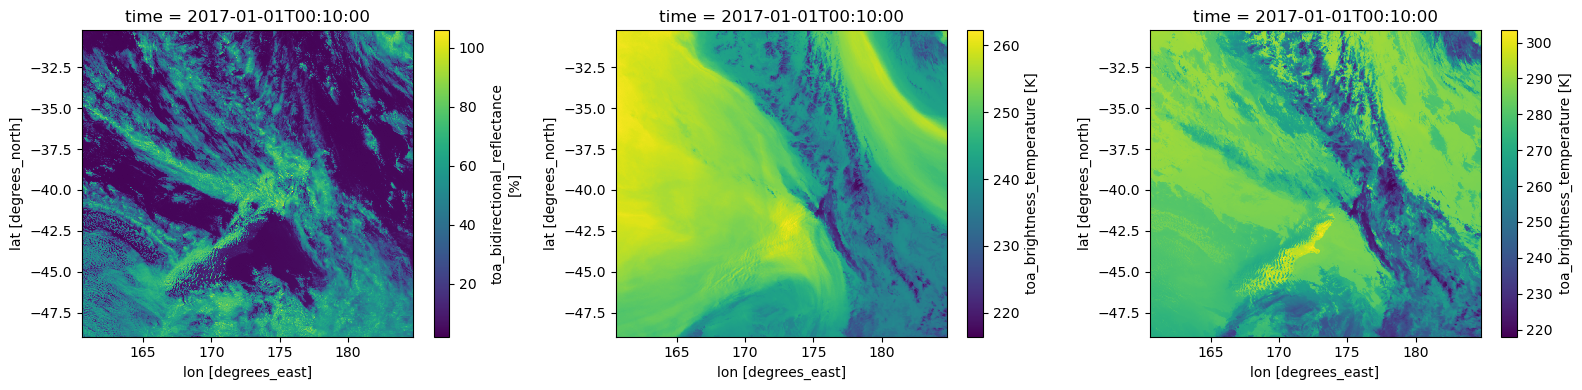

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
h8_ds.isel(time=0)[BAND_3].plot(ax=ax[0])
h8_ds.isel(time=0)[BAND_9].plot(ax=ax[1])
h8_ds.isel(time=0)[BAND_13].plot(ax=ax[2])

plt.tight_layout()

#### NZRA
Visualise temperature from the NZRA dataset.

This will be sampled from and used as the target set.

For initial experiments, the target is 'temperature' but will be updated as use-cases require.

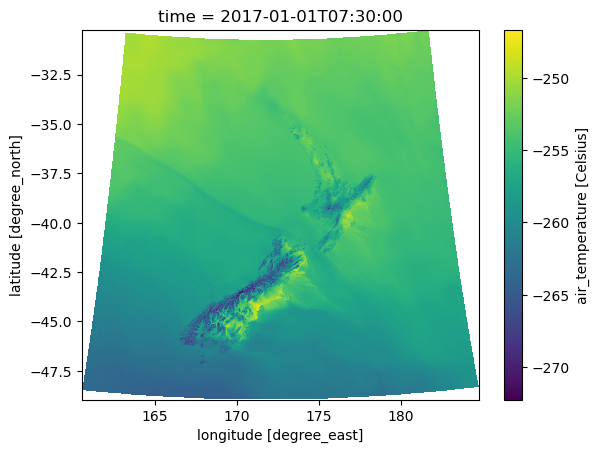

In [19]:
nzra_ds[target_variable].isel(time=9).plot()

#### Auxiliary
Elevation, TPI, and land/sea mask.

This is auxiliary - i.e. constant across time.

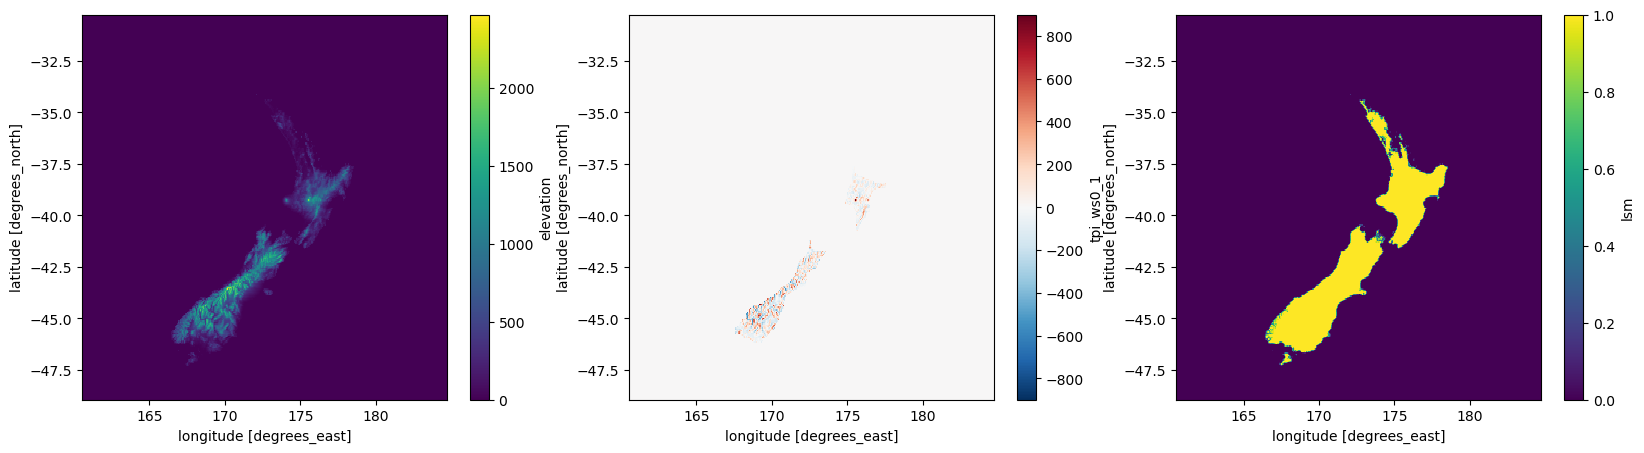

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ds_aux_coarse[ELEVATION].plot(ax=ax[0])
ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[1])
ds_aux_coarse[LAND_SEA_MASK].plot(ax=ax[2])

#### ERA5
The following six variables together form a closed description of the atmosphere. We may include all these variables in the model.

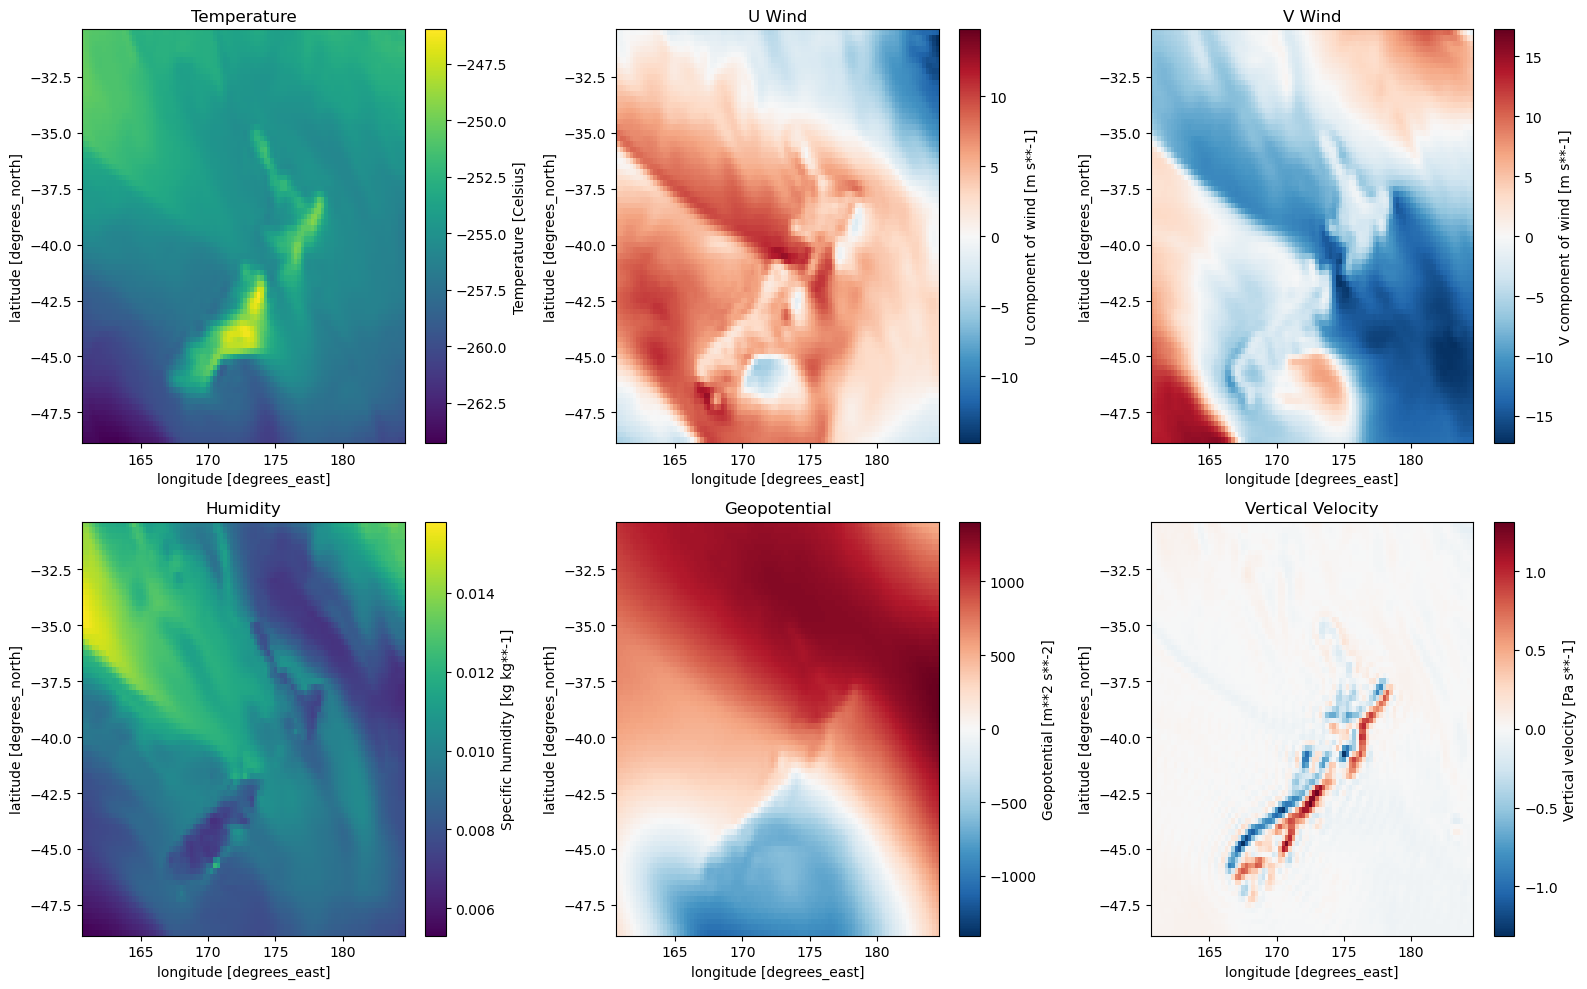

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

era5_ds[TEMPERATURE].isel(time=0).plot(ax=ax[0, 0])
ax[0, 0].set_title("Temperature")

era5_ds[WIND_U].isel(time=0).plot(ax=ax[0, 1])
ax[0, 1].set_title("U Wind")

era5_ds[WIND_V].isel(time=0).plot(ax=ax[0, 2])
ax[0, 2].set_title("V Wind")

era5_ds[HUMIDITY].isel(time=0).plot(ax=ax[1, 0])
ax[1, 0].set_title("Humidity")

era5_ds[GEOPOTENTIAL].isel(time=0).plot(ax=ax[1, 1])
ax[1, 1].set_title("Geopotential")

era5_ds[VERTICAL_VELOCITY].isel(time=0).plot(ax=ax[1, 2])
ax[1, 2].set_title("Vertical Velocity")
plt.tight_layout()

#### ERA5 Sun Position Annotations

The sun culmination and sun angle have been added as extra channels to ERA5 to encode time of year and time of day respectively.

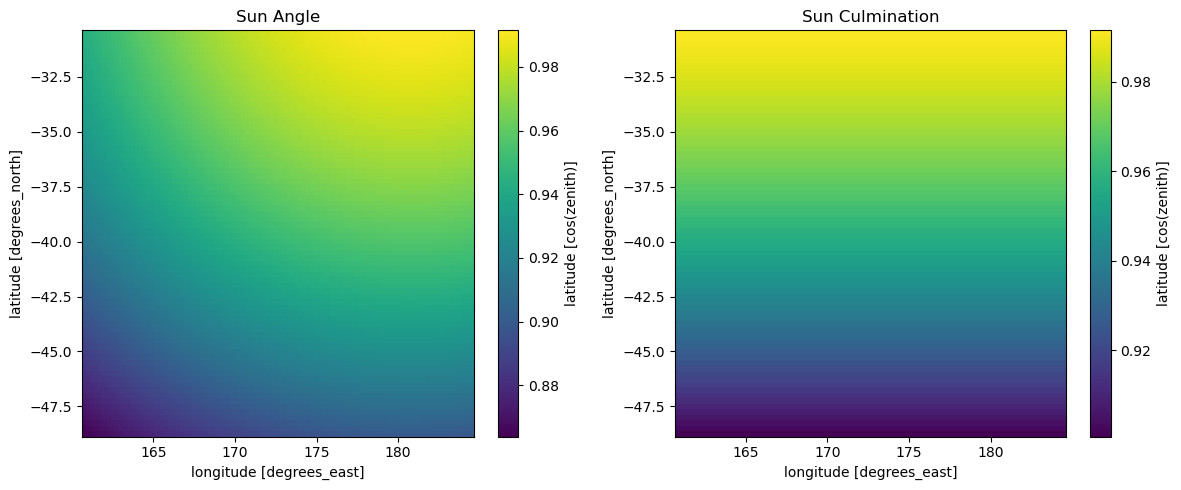

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

era5_ds[SUN_ANGLE].isel(time=0).plot(ax=ax[0])
ax[0].set_title("Sun Angle")

era5_ds[SUN_CULMINATION].isel(time=0).plot(ax=ax[1])
ax[1].set_title("Sun Culmination")

plt.tight_layout()

#### Ground Stations

A subset (and arbitrary number) of ground stations will be used as off-grid inputs to the model.

A set of stations can also be used as supplementary target points to NZRA - letting the model learn at spaces off the NZRA grid, and theoretically allowing the model to learn outputs which could be "more correct" than NZRA - provided the stations haven't been assimilated into NZRA.

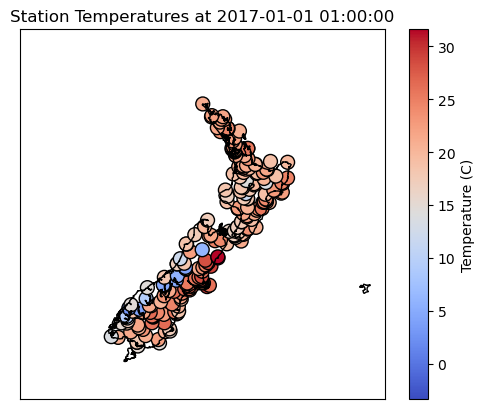

In [29]:
time_step = "2017-01-01 01:00:00"
m = Basemap(projection='merc', llcrnrlat=nzra_ds[LATITUDE].min().item(), urcrnrlat=nzra_ds[LATITUDE].max().item(), llcrnrlon=nzra_ds[LONGITUDE].min().item(), urcrnrlon=nzra_ds[LONGITUDE].max().item(), resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()